In [1]:
import os
import csv
import PIL
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

from utils.utils import *
from models.yolov3 import *
from datasets import DetectDataset
from interpretation import YoloInterpretation
from models.yolov3_baseline import YOLOv3

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
checkout_path = '/home/cell/hdh/yolo/outcomes/(08-04_09:10)'
valid_csv_path = '/home/cell/hdh/yolo/data/rm_data/train/valid.csv'

In [9]:
test_ds = DetectDataset.create_by_csv(valid_csv_path, augment=False, normalized_labels=True, multiscale=False, binary_class=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=12, collate_fn=test_ds.collate_fn)

In [10]:
model = YOLOv3(3, 80, 416)

In [11]:
model.load_state_dict(torch.load(os.path.join(checkout_path, 'models', 'best_mAP.pth')))

<All keys matched successfully>

In [12]:
_ = model.eval()
_ = model.cuda()

In [13]:
conf_thres = 0.4
nms_thres = 0.5
iou_thres = 0.5

In [14]:
save_img_paths = []
save_img_tensor = []
save_outputs = []
save_predicts = []
save_y_trues = []

labels = []
sample_metrics = []  # List of tuples (TP, confs, pred)

with torch.no_grad():
    for it, batch in enumerate(test_dl):
        image_paths, x, y = batch
        save_img_paths.extend(image_paths)
        x = x.to('cuda')
        y = y.to('cuda')
        # split each image
        for it in range(x.shape[0]):
            save_img_tensor.append(x[it, ...].detach().cpu())

        # split each image y_true
        targets = y.clone()
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= model.img_dim
        batch_its = torch.unique(targets[:, 0])
        for it in batch_its:
            save_y_trues.append(targets[targets[:, 0]==it, ...][:, 1:].detach().cpu())

        loss, outputs = model(x, y)
        # split each image output
        for it in range(outputs.shape[0]):
            save_outputs.append(outputs[it, ...].detach().cpu())

        # get predict
        predicts = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)
        for it in range(len(predicts)):
            save_predicts.append(predicts[it])

        labels += y[:, 1].tolist()
        sample_metrics += get_batch_statistics(predicts, targets.detach().cpu(), iou_threshold=iou_thres)

interp = YoloInterpretation.create_valid_interp(test_dl, model, save_outputs, save_predicts, save_y_trues)
true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)
print(precision, recall, AP, f1, ap_class)

[0.43762781 0.36697248 0.45868465 0.04694836 0.22501273] [0.9315148  0.66666667 0.89768977 0.15789474 0.61789376] [0.48367796 0.27489802 0.69208898 0.0645406  0.25427559] [0.59549207 0.47337278 0.60714286 0.07237636 0.32989178] [0 1 2 3 4]


In [21]:
from PIL import ImageDraw

In [22]:
index = [1, 2, 3, 4]

In [34]:
result_gt_img = []
for i in index:
    img_tensor = save_img_tensor[i]
    y_true = save_y_trues[i]
    img = T.ToPILImage()(img_tensor)
    draw = ImageDraw.Draw(img)
    for box in y_true:
        if int(box[-1].item()) != 0:
            continue
        draw.rectangle(box[1:].tolist(), width=2)
#         draw.text(box[1:3].tolist(), f'class id: {int(box[0].item())}', fill='black')
    result_gt_img.append(img)

In [35]:
result_pr_img = []
for i in index:
    img_tensor = save_img_tensor[i]
    predict = save_predicts[i]
    img = T.ToPILImage()(img_tensor)
    draw = ImageDraw.Draw(img)
    for box in predict:
        if int(box[-1].item()) != 0:
            continue
        draw.rectangle(box[0:4].tolist(), width=2)
#         draw.text(box[0:2].tolist(), f'class id: {int(box[-1].item())}', fill='black')
    result_pr_img.append(img)

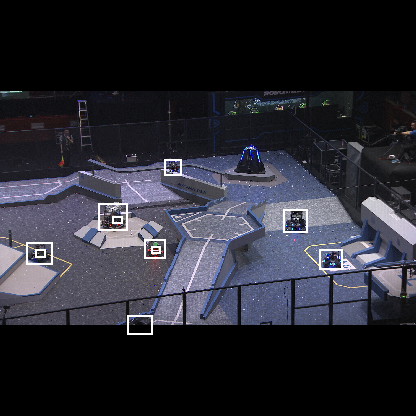

In [36]:
result_pr_img[0]

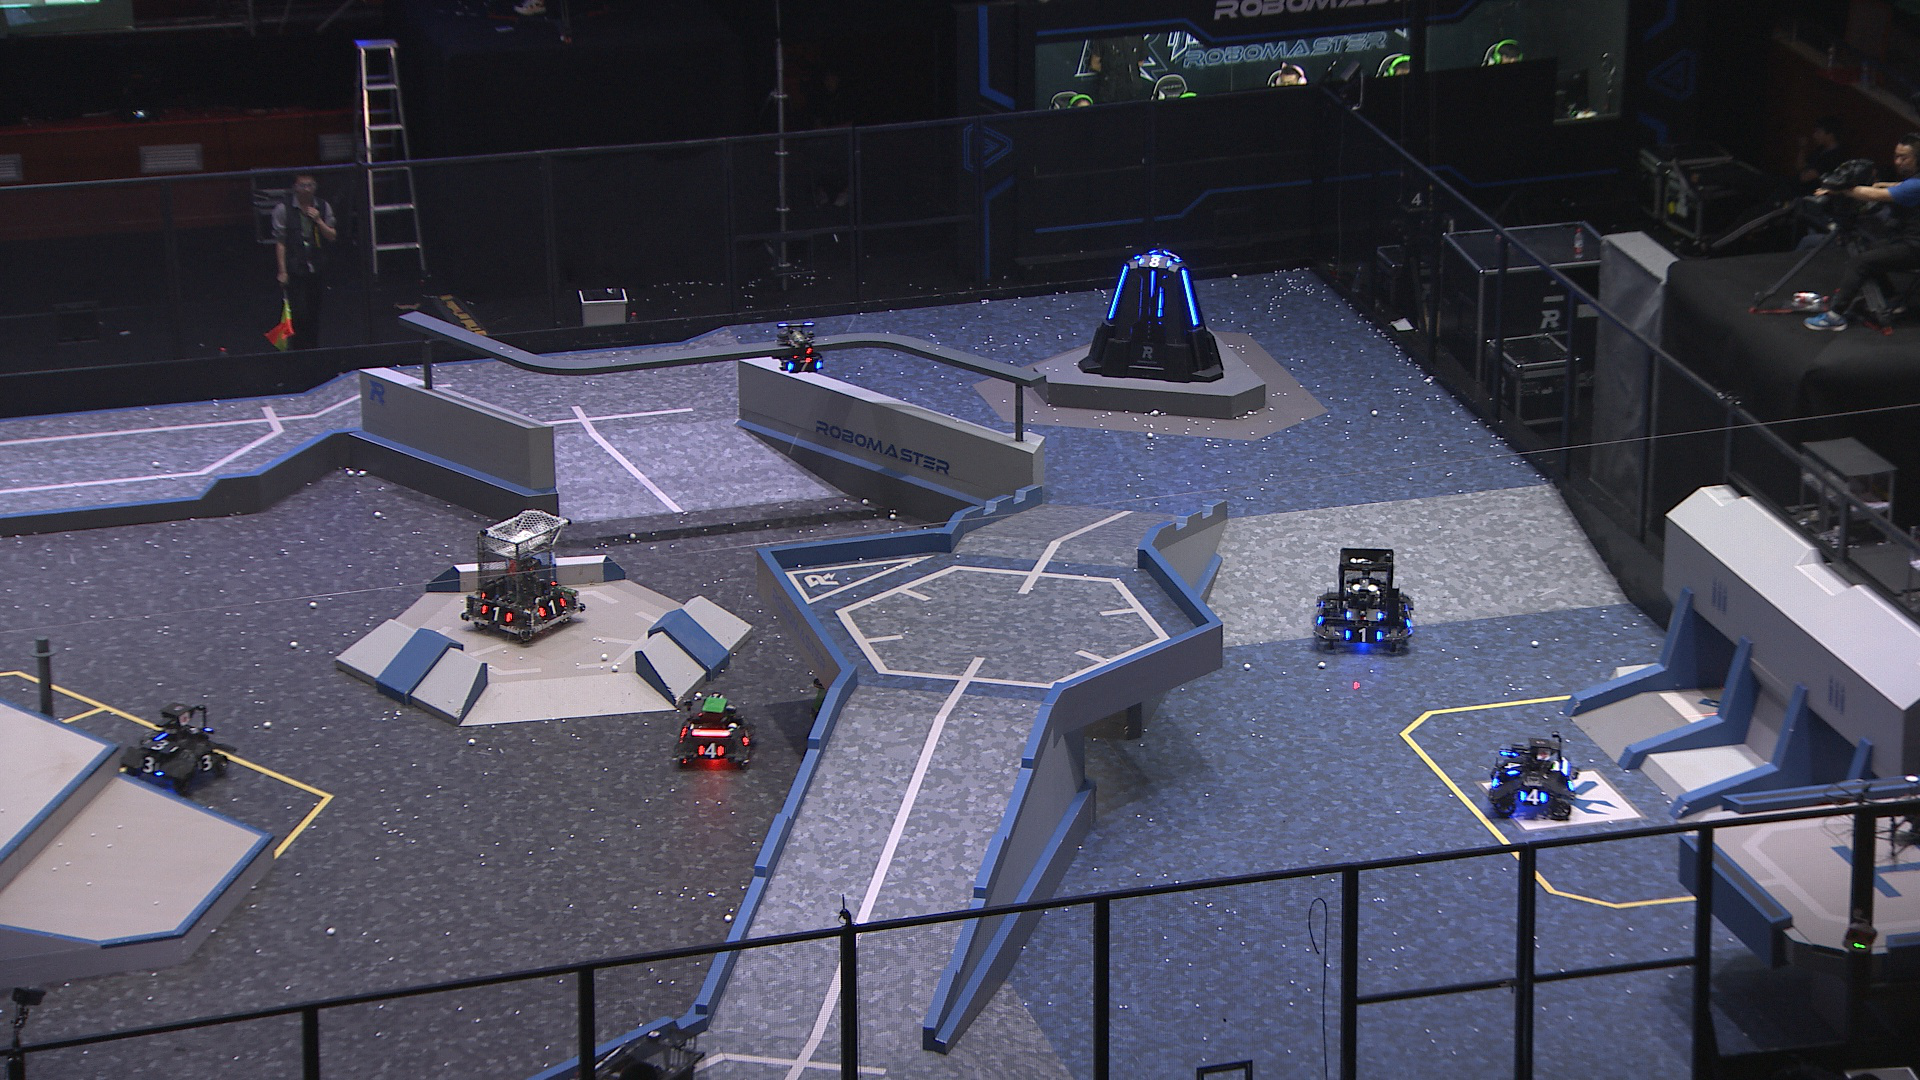

In [38]:
PIL.Image.open(save_img_paths[1])

In [58]:
import os
import torch
import torchvision.transforms as transforms
from utils.utils import *
from models.yolov3_baseline import YOLOv3
import PIL
import numpy as np
import torch.nn.functional as F

checkout_path = '/home/cell/hdh/yolo/outcomes/RM继续训练/(08-04_14:05)/models/best_mAP.pth'
conf_thres = 0.7
nms_thres = 0.5
iou_thres = 0.3
img_size = 416

class Detector(object):
    def __init__(self, checkout_path, img_size, conf_thres, nms_thres, iou_thres):        
        self.model = YOLOv3(3, 80, img_size)
        self.model.load_state_dict(torch.load(checkout_path))
        _ = self.model.eval()
        _ = self.model.cuda()
        
        self.img_size = img_size
        self.conf_thres = conf_thres
        self.nms_thres = nms_thres
        self.iou_thres = iou_thres
        pass
    
    @staticmethod
    def pad_image(img, pad_value):
        c, h, w = img.shape
        dim_diff = np.abs(h - w)
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
        img = F.pad(img, pad, "constant", value=pad_value)
        return img, pad
    
    def detect(self,images):
        """input PIL RGB image or image list"""
        # preprocess
        list_flag = 1
        if not isinstance(images, list):
            images = [images]
            list_flag = 0
        image_tensor_list = []
        for image in images:
            img_tensor = transforms.ToTensor()(image)
            img_tensor, pad = Detector.pad_image(img_tensor, 0)
            img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=self.img_size, mode="nearest").squeeze(0)
            image_tensor_list.append(img_tensor)
        # detect
        input_x = torch.cat([i.unsqueeze(0) for i in image_tensor_list], dim=0)
        input_x = input_x.to('cuda')
        outputs = self.model(input_x)
        img_detections = non_max_suppression(outputs, conf_thres=self.conf_thres, nms_thres=self.nms_thres)
        # get result
        ret_boxes = []
        for i, (image, detections) in enumerate(zip(images, img_detections)):
            # detections type one-image n*(x1, y1, x2, y2, conf, cls_conf, cls_pred)
            detections = rescale_boxes(detections, self.img_size, image.size[::-1])
            ret_boxes.append(detections)
        if not list_flag:
            ret_boxes = ret_boxes[0]
        return ret_boxes

In [59]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
detector = Detector(checkout_path, img_size, conf_thres, nms_thres, iou_thres)

In [69]:
image = PIL.Image.open('/home/cell/hdh/yolo/data/rm_data/train/images/0.jpg')

In [70]:
ret_boxes = detector.detect(image)

In [71]:
ret_boxes

tensor([[ 1.3409e+03,  5.0195e+02,  1.3646e+03,  5.2120e+02,  9.9978e-01,
          9.9994e-01,  4.0000e+00],
        [ 1.6254e+03,  6.6171e+02,  1.6631e+03,  6.8561e+02,  9.9967e-01,
          9.9998e-01,  4.0000e+00],
        [ 1.5834e+03,  8.3422e+02,  1.6200e+03,  8.6167e+02,  9.9964e-01,
          9.9998e-01,  4.0000e+00],
        [ 1.6354e+03,  4.6294e+02,  1.6605e+03,  4.8279e+02,  9.9962e-01,
          9.9987e-01,  4.0000e+00],
        [ 1.3870e+03,  4.9855e+02,  1.4090e+03,  5.1823e+02,  9.9968e-01,
          9.9979e-01,  4.0000e+00],
        [ 1.1298e+02,  6.8553e+02,  1.3749e+02,  7.1005e+02,  9.9918e-01,
          9.9998e-01,  4.0000e+00],
        [ 3.8952e+02,  6.7021e+02,  4.1318e+02,  6.9191e+02,  9.9906e-01,
          1.0000e+00,  4.0000e+00],
        [ 1.3651e+03,  4.8669e+02,  1.4019e+03,  5.1592e+02,  9.9996e-01,
          9.9885e-01,  4.0000e+00],
        [ 1.5751e+03,  6.5180e+02,  1.6025e+03,  6.7619e+02,  9.9733e-01,
          9.9996e-01,  4.0000e+00],
        [ 

In [72]:
from PIL import ImageDraw

In [73]:
draw = ImageDraw.Draw(image)

In [74]:
for x1, y1, x2, y2, conf, cls_conf, cls_pred in ret_boxes:
    if cls_pred.item() == 0:
        draw.rectangle([x1, y1, x2, y2], width=2)

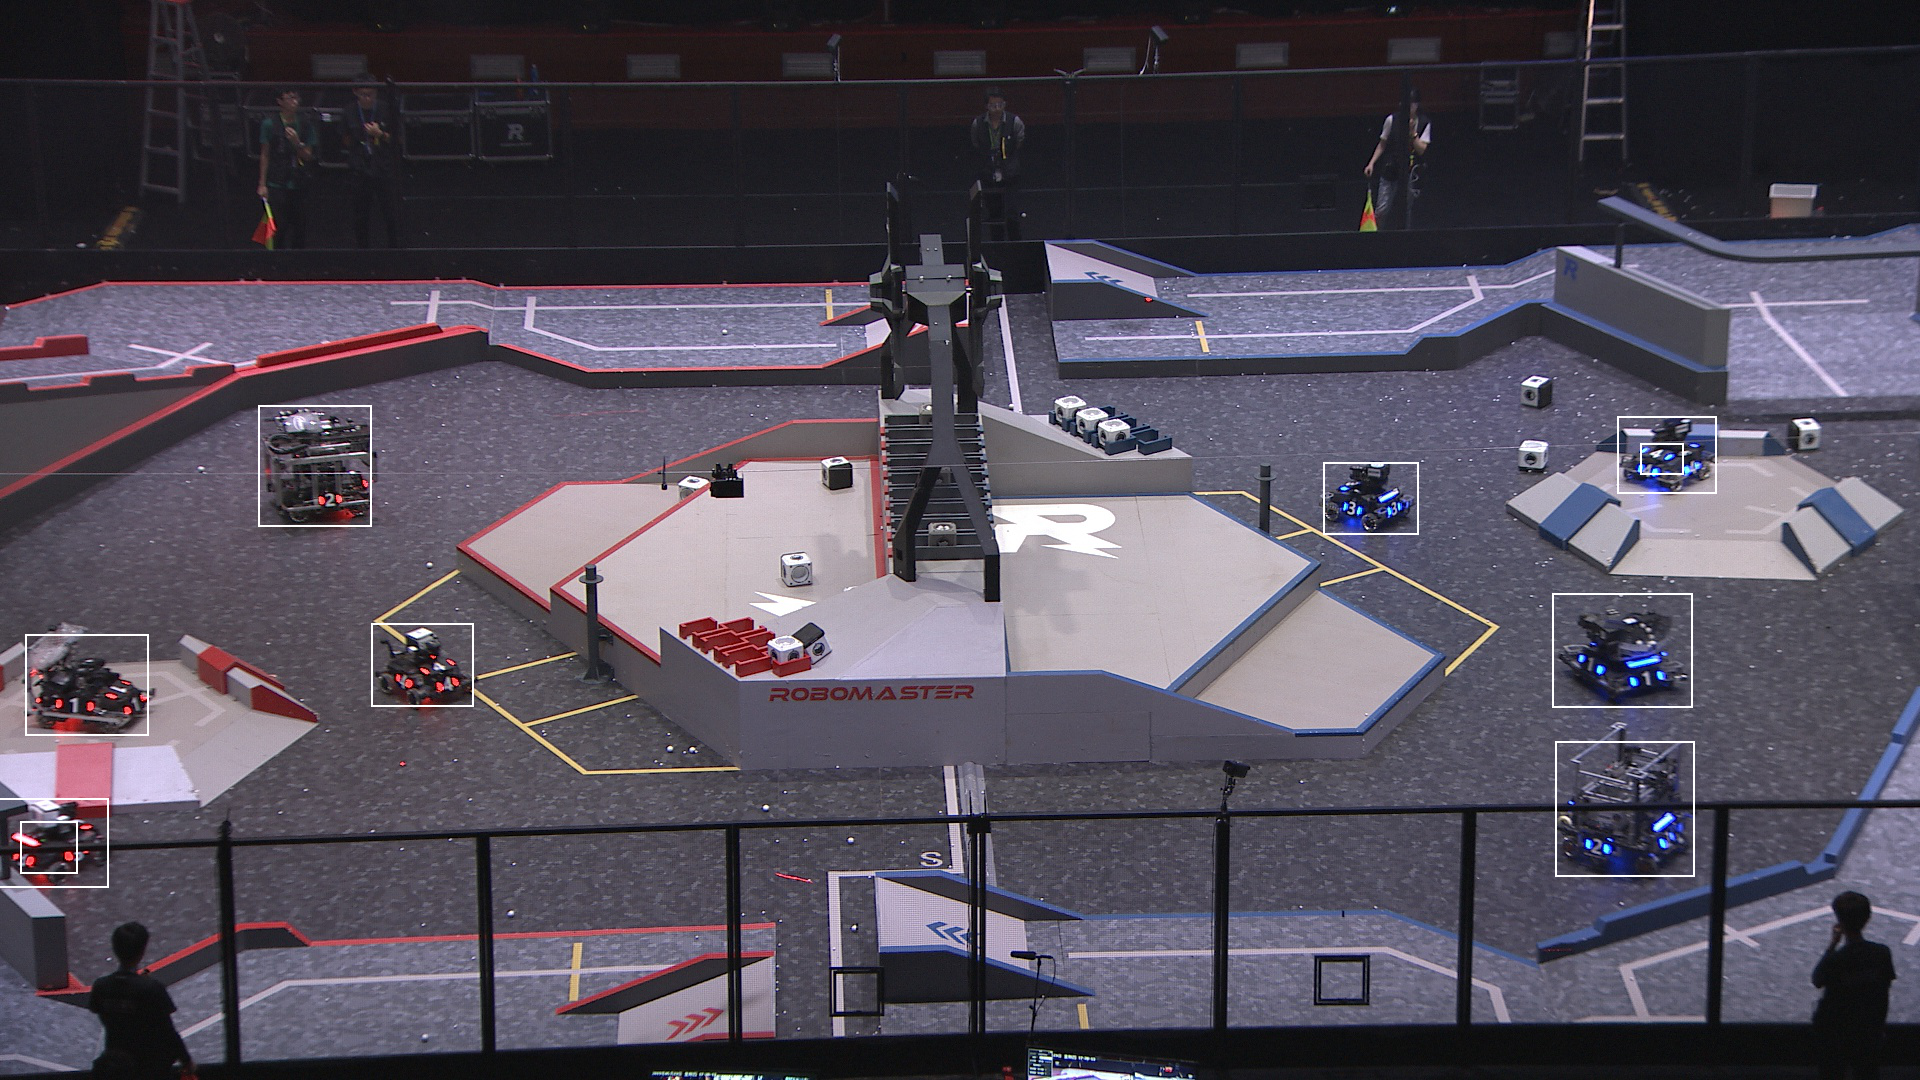

In [75]:
image

In [38]:
image.size

(1920, 1080)

In [39]:
np.array(image).shape[:2]

(1080, 1920)